In [34]:
import matplotlib.pyplot as plt

In [35]:
class point:
    def __init__(self,coordx,coordy):
        self.x = coordx
        self.y = coordy

class group:
    points_group = []
    def __init__(self):
        self.points_group = []

    def add_point(self,point):
        self.points_group.append(point)

In [63]:
def distanceSqr(a, b) -> float:
    result = (a[0] - b[0])**2 + (a[1] - b[1])**2
    return result

In [37]:
# lendo arquivo de entrada e criando lista de pontos
# abrindo arquivo para leitura
file = open("banana.dat","r")
lines = file.readlines()
# filtrando linhas retirando tudo ate a linha @data
lines = lines[lines.index("@data\n")+1:]

# separando as linhas para 70% treino e 30% teste
treinamento = lines[:int(len(lines)*0.7)]
teste = lines[int(len(lines)*0.7):]

# criando grupos
group1 = group()
group2 = group()

# preenchendo grupos com pontos, sendo que grupo1 sao os pontos da classe 1.0 e grupo2 sao os pontos da classe -1.0
for line in treinamento:
    line = line.split(',')
    if float(line[2]) == 1.0:
        group1.add_point(point(float(line[0]),float(line[1])))
    else:
        group2.add_point(point(float(line[0]),float(line[1])))

# ordenando os pontos de cada grupo em ordem do menor y para o maior y
# para criterio de desempate, ordena-se pelo menor x
group1.points_group.sort(key=lambda point: (point.y,point.x))
group2.points_group.sort(key=lambda point: (point.y,point.x))

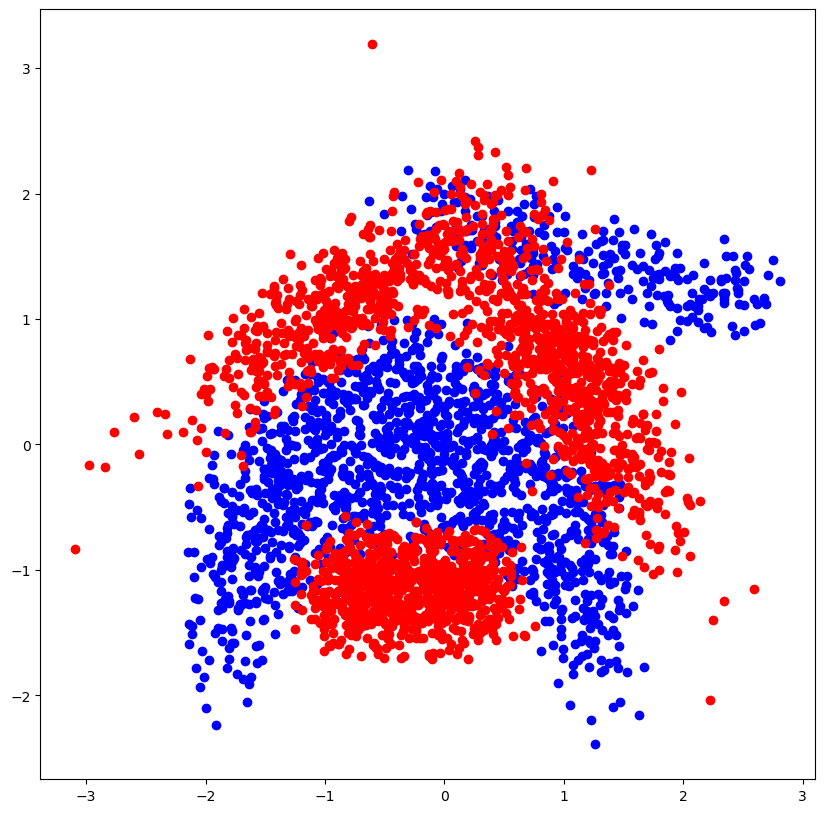

In [38]:
# plotando pontos
# criando figura
fig = plt.figure(figsize=(10,10))
# criando subplot
ax = fig.add_subplot(111)
# plotando pontos do grupo 1
for point in group1.points_group:
    ax.scatter(point.x,point.y,color='b')
# plotando pontos do grupo 2
for point in group2.points_group:
    ax.scatter(point.x,point.y,color='r')
# mostrando figura
plt.show()

## Plot feixo convexo do conjunto dos pontos em dois gráficos separados

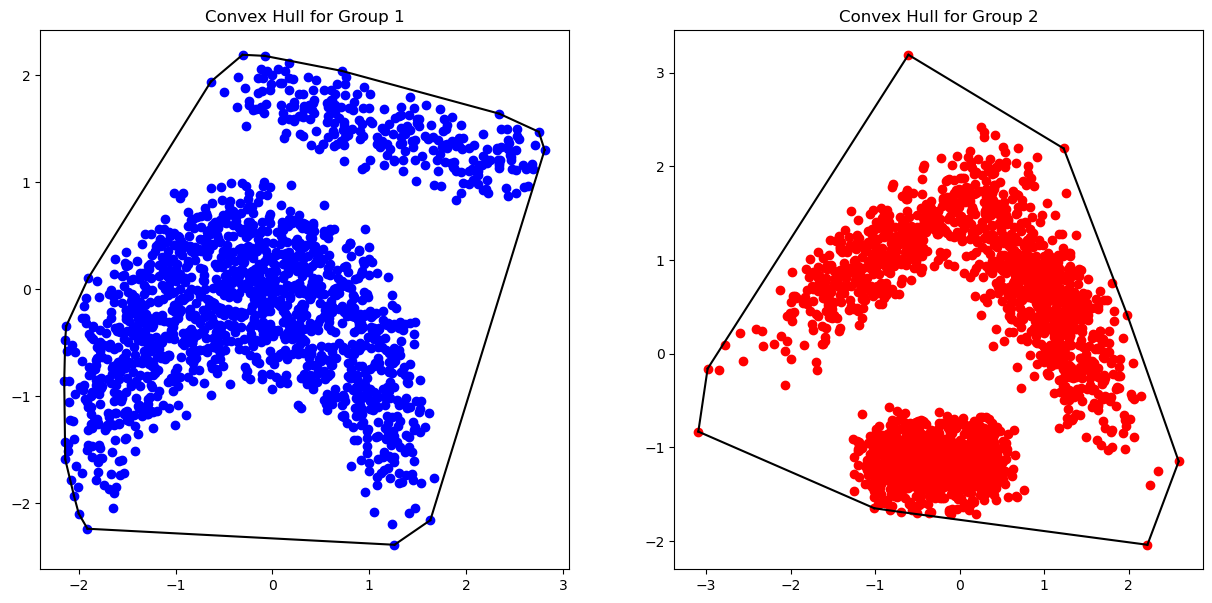

In [39]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

# Agrupando pontos dos dois grupos
points_group1 = np.array([[point.x, point.y] for point in group1.points_group])
hull_group1 = ConvexHull(points_group1)

points_group2 = np.array([[point.x, point.y] for point in group2.points_group])
hull_group2 = ConvexHull(points_group2)

# Criando plot para os dois convex hulls
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot pontos grupo 1
axes[0].scatter(points_group1[:, 0], points_group1[:, 1], color='b')
for simplex in hull_group1.simplices:
    axes[0].plot(points_group1[simplex, 0], points_group1[simplex, 1], 'k-')
axes[0].set_title('Convex Hull for Group 1')

# Plot pontos grupo 2
axes[1].scatter(points_group2[:, 0], points_group2[:, 1], color='r')
for simplex in hull_group2.simplices:
    axes[1].plot(points_group2[simplex, 0], points_group2[simplex, 1], 'k-')
axes[1].set_title('Convex Hull for Group 2')

plt.show()

## Plot do feixo convexo do conjunto dos pontos em um gráfico só

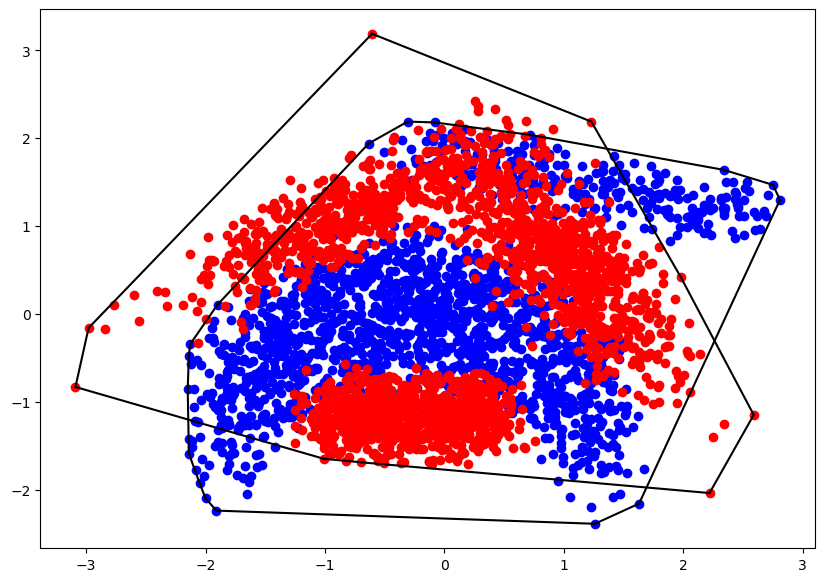

In [40]:
# Cria uma figura para visualizar os resultados
fig, ax = plt.subplots(figsize=(10, 7))

# Plota pontos do grupo 1
ax.scatter(points_group1[:, 0], points_group1[:, 1], color='b', label='Group 1')

# Plota pontos do grupo 2
ax.scatter(points_group2[:, 0], points_group2[:, 1], color='r', label='Group 2')

# Plota as envoltórias convexas dos dois grupos
for simplex in hull_group1.simplices:
    ax.plot(points_group1[simplex, 0], points_group1[simplex, 1], 'k-')
for simplex in hull_group2.simplices:
    ax.plot(points_group2[simplex, 0], points_group2[simplex, 1], 'k-')

In [68]:
def closestPoints(hull_group1, hull_group2):
    # Inicialize com o maior valor possível para garantir que qualquer distância encontrada seja menor
    minDistance = float('inf')
    
    # Inicializa o par de vértices mais próximos como vazio
    closestPoints = None
    
    #percorre os vértices de ambos salvando o menor valor e os pontos correspondentes

    for vertex1 in hull_group1.vertices:
        for vertex2 in hull_group2.vertices:
            distance = distanceSqr(points_group1[vertex1],points_group2[vertex2])
            if distance < minDistance:
                minDistance = distance
                closestPoints = (points_group1[vertex1], points_group2[vertex2])

    return closestPoints

In [69]:
print(closestPoints(hull_group1, hull_group2))

(array([0.713, 2.04 ]), array([1.23, 2.19]))
